# Task:2 Predicting Future Sales (Regression Model)

## Wallmart Sales Forecasting

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/BUFONJOKER/ml-ds-internship/blob/master/Task2/Task2wallmartsalesforecastingmodel.ipynb" target="_parent">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"
      style="height:80px; width:auto;"/>
    </a>
  </td>
</table>

Task2/

In [272]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score
)

## Exploratory Data Analysis (EDA)

In [273]:
# load the dataset
df_train = pd.read_csv('wallmart_sales_forecasting.csv')
df_stores = pd.read_csv('stores.csv')
df_features = pd.read_csv('features.csv')

In [274]:
# take a look at first 4 rows
df_train.head(4)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False


In [275]:
# take a look at first 4 rows
df_stores.head(4)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863


In [276]:
# take a look at first 4 rows
df_features.head(4)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False


In [277]:
# merging train data with stores data on 'Store' column
df = df_train.merge(df_stores, on=['Store'])

In [278]:
# now trying to merge train data with features data
#  on 'Store' and 'Date' columns
df = df_train.merge(df_features, on=['Store','Date'])

In [279]:
# take a look at first few rows of the
# final merged dataframe which
# we will use for analysis and modeling
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [280]:
# checking rows and columns count
df.shape

(421570, 15)

In [281]:
# checking the sum of null values in each column
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
dtype: int64

In [282]:
# Mrkdown1,2,3,4,5 has more than 50% missing values so better to remove
# and also holiday column appear twice
df.drop(['IsHoliday_x','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],
        axis=1,inplace=True)

In [283]:
# checking the first 2 rows of the cleaned dataframe
df.head(2)

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,38.51,2.548,211.242170,8.106,True


In [284]:
# renaming the 'IsHoliday_y' column to 'IsHoliday'
df.rename(columns={"IsHoliday_y":"IsHoliday"},
inplace=True)

In [285]:
# check top few rows
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,38.51,2.548,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,39.93,2.514,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,46.63,2.561,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,46.50,2.625,211.350143,8.106,False


# 🏪 Walmart Weekly Sales Dataset — Column Descriptions

| **Column Name** | **Description** |
|------------------|------------------|
| **Store** | The unique **store ID** — identifies which Walmart store the record belongs to. |
| **Dept** | The **department number** within the store (e.g., Electronics, Grocery, Clothing). |
| **Date** | The **week-ending date** (YYYY-MM-DD format) for that record’s sales data. Each row represents one week of sales. |
| **Weekly_Sales** | The **total sales (in dollars)** for that store and department during that week. |
| **Temperature** | The **average temperature (°F)** in the region of the store during that week — can affect customer shopping behavior. |
| **Fuel_Price** | The **average cost of fuel (per gallon)** in the region — often used as an economic indicator. |
| **CPI** | **Consumer Price Index** — measures inflation; helps track changes in the cost of living over time. |
| **Unemployment** | The **unemployment rate (%)** in the store’s region during that week — reflects local economic conditions. |
| **IsHoliday** | A **Boolean flag (True/False)** indicating whether that week includes a major U.S. holiday (e.g., Thanksgiving, Christmas, Super Bowl). |


In [286]:
# change date column to date time
df['Date'] = pd.to_datetime(df['Date'])

In [287]:
# extract year, month, week and day from date column
# and create new columns for each
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day

In [288]:
# extract day of week
df['Date'].dt.dayofweek

0         4
1         4
2         4
3         4
4         4
         ..
421565    4
421566    4
421567    4
421568    4
421569    4
Name: Date, Length: 421570, dtype: int32

In [289]:
# extract week of year
df['Date'].dt.isocalendar().week

0          5
1          6
2          7
3          8
4          9
          ..
421565    39
421566    40
421567    41
421568    42
421569    43
Name: week, Length: 421570, dtype: UInt32

In [290]:
# check unique values in Temperature column
df['Temperature'].unique()

array([42.31, 38.51, 39.93, ..., 75.87, 77.55, 74.09], shape=(3528,))

In [291]:
# check count of missing values in each columns
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday       0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [292]:
# quick summary of the descriptive statistics
df.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,171.201947,7.960289,2010.968591,6.449510,25.826762,15.673131
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.0,1.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,132.022667,6.891000,2010.000000,4.000000,14.0,8.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,182.318780,7.866000,2011.000000,6.000000,26.0,16.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,212.416993,8.572000,2012.000000,9.000000,38.0,23.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,52.0,31.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,39.159276,1.863296,0.796876,3.243217,14.151887,8.753549


In [293]:
# no. of rows and columns in dataframe
df.shape

(421570, 13)

In [294]:
# name of columns
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')

In [295]:
# data types of each column
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
dtype: object

In [296]:
# unique values in store column
df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [297]:
# unique values in Dept column
df['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

In [298]:
# take a look at first 10 rows
df.head(10)

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,Day
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,False,2010,2,5,5
1,1,1,2010-02-12,46039.49,38.51,2.548,211.242170,8.106,True,2010,2,6,12
2,1,1,2010-02-19,41595.55,39.93,2.514,211.289143,8.106,False,2010,2,7,19
3,1,1,2010-02-26,19403.54,46.63,2.561,211.319643,8.106,False,2010,2,8,26
4,1,1,2010-03-05,21827.90,46.50,2.625,211.350143,8.106,False,2010,3,9,5
5,1,1,2010-03-12,21043.39,57.79,2.667,211.380643,8.106,False,2010,3,10,12
6,1,1,2010-03-19,22136.64,54.58,2.720,211.215635,8.106,False,2010,3,11,19
7,1,1,2010-03-26,26229.21,51.45,2.732,211.018042,8.106,False,2010,3,12,26
8,1,1,2010-04-02,57258.43,62.27,2.719,210.820450,7.808,False,2010,4,13,2
9,1,1,2010-04-09,42960.91,65.86,2.770,210.622857,7.808,False,2010,4,14,9


In [299]:
# descriptive statistics of the dataframe
df.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,171.201947,7.960289,2010.968591,6.449510,25.826762,15.673131
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.0,1.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,132.022667,6.891000,2010.000000,4.000000,14.0,8.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,182.318780,7.866000,2011.000000,6.000000,26.0,16.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,212.416993,8.572000,2012.000000,9.000000,38.0,23.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,52.0,31.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,39.159276,1.863296,0.796876,3.243217,14.151887,8.753549


In [300]:
# correlation of each feature
# with target variable Weekly_Sales
df.corr()['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales    1.000000
Dept            0.148032
Month           0.028409
Week            0.027673
IsHoliday       0.012774
Fuel_Price     -0.000120
Date           -0.000663
Temperature    -0.002312
Day            -0.006187
Year           -0.010111
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Name: Weekly_Sales, dtype: float64

In [301]:
# columns in the dataframe
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')

In [302]:
# data types of each column
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
dtype: object

In [303]:
# descriptive statistics of
# target variable Weekly_Sales
df['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [304]:
# check for negative values in
# target variable Weekly_Sales
df[(df['Weekly_Sales']<0)]

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,Day
846,1,6,2012-08-10,-139.65,85.05,3.494,221.958433,6.908,False,2012,8,32,10
2384,1,18,2012-05-04,-1.27,75.55,3.749,221.671800,7.143,False,2012,5,18,4
6048,1,47,2010-02-19,-863.00,39.93,2.514,211.289143,8.106,False,2010,2,7,19
6049,1,47,2010-03-12,-698.00,57.79,2.667,211.380643,8.106,False,2010,3,10,12
6051,1,47,2010-10-08,-58.00,63.93,2.633,211.746754,7.838,False,2010,10,40,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,27.73,2.773,181.982317,8.992,True,2010,2,6,12
419598,45,80,2010-02-19,-0.27,31.27,2.745,182.034782,8.992,False,2010,2,7,19
419603,45,80,2010-04-16,-1.61,54.28,2.899,181.692477,8.899,False,2010,4,15,16
419614,45,80,2010-07-02,-0.27,76.61,2.815,182.318780,8.743,False,2010,7,26,2


In [305]:
# remove rows with negative Weekly_Sales values
# and create a new dataframe
df = df[df['Weekly_Sales']>0]

In [306]:
# count of negative Weekly_Sales values
(df['Weekly_Sales']<0).sum()

np.int64(0)

In [307]:
# check for duplicate rows in the dataframe
df.duplicated().sum()

np.int64(0)

In [308]:
# group by Store and sum Weekly_Sales
weekly_sales_store = df.groupby('Store')['Weekly_Sales'].sum()

In [309]:
# top 10 stores with highest total Weekly_Sales
top_10_stores_weekly_sales = weekly_sales_store.sort_values(ascending=False).head(10)

In [310]:
# display the top 10 stores with
# highest total Weekly_Sales
top_10_stores_weekly_sales

Store
20    3.014014e+08
4     2.995453e+08
14    2.890019e+08
13    2.865180e+08
2     2.753872e+08
10    2.716241e+08
27    2.538572e+08
6     2.237586e+08
1     2.224068e+08
39    2.074465e+08
Name: Weekly_Sales, dtype: float64

In [311]:
# columns in the dataframe
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')

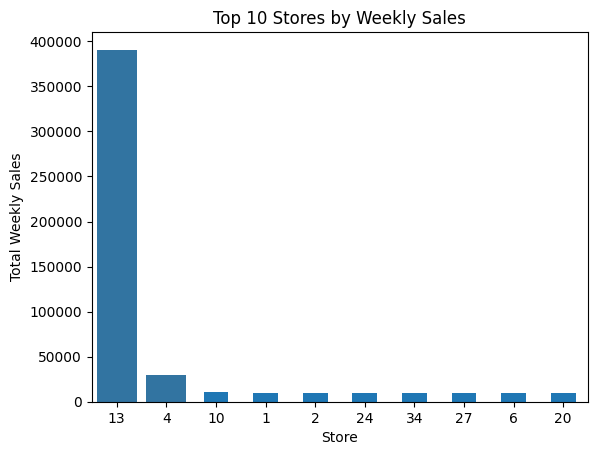

In [312]:
# plot top 10 stores with highest total Weekly_Sales
df['Store'].value_counts().head(10).plot(kind='bar')
sns.countplot(x='IsHoliday', data=df)
plt.title('Top 10 Stores by Weekly Sales')
plt.xlabel('Store')
plt.ylabel('Total Weekly Sales')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.show()

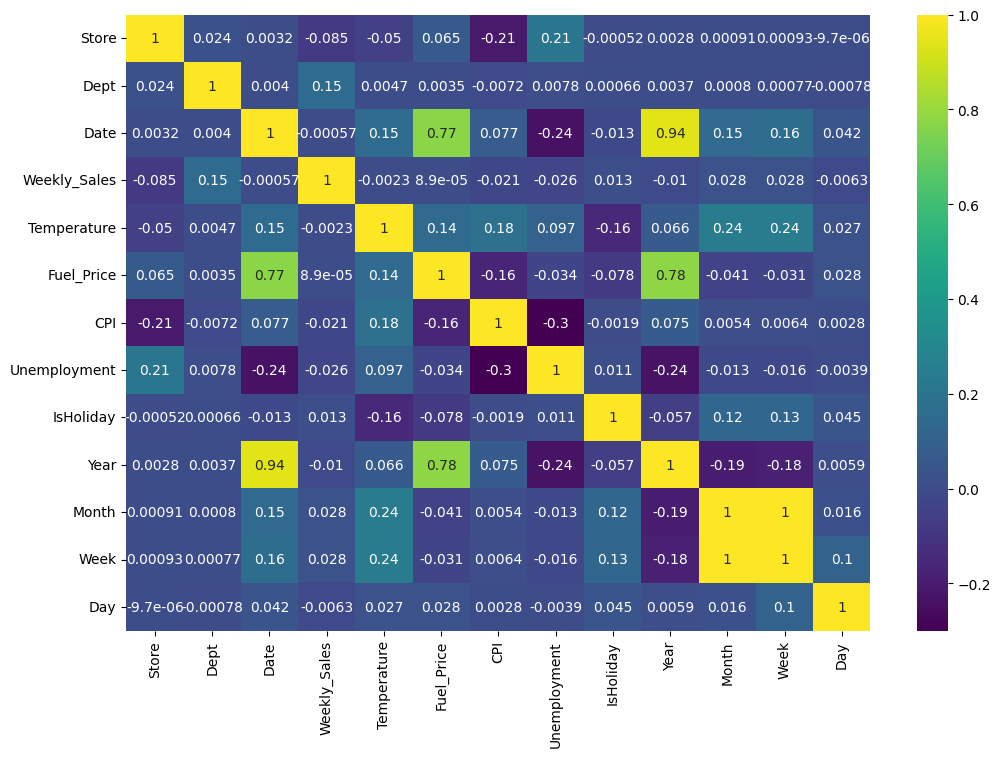

In [313]:
# plot correlation heatmap of features
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.show()

In [314]:
# correlation of selected features with Weekly_Sales
df[['Weekly_Sales',"Temperature",'IsHoliday','Month','Fuel_Price','Week','Day']].corr()

,Weekly_Sales,Temperature,IsHoliday,Month,Fuel_Price,Week,Day
Weekly_Sales,1.000000,-0.002339,0.012843,0.028401,0.000089,0.027659,-0.006265
Temperature,-0.002339,1.000000,-0.155775,0.235957,0.143700,0.236256,0.026888
IsHoliday,0.012843,-0.155775,1.000000,0.123058,-0.078155,0.127846,0.045196
Month,0.028401,0.235957,0.123058,1.000000,-0.040931,0.996000,0.016240
Fuel_Price,0.000089,0.143700,-0.078155,-0.040931,1.000000,-0.031191,0.028098
Week,0.027659,0.236256,0.127846,0.996000,-0.031191,1.000000,0.104585
Day,-0.006265,0.026888,0.045196,0.016240,0.028098,0.104585,1.000000


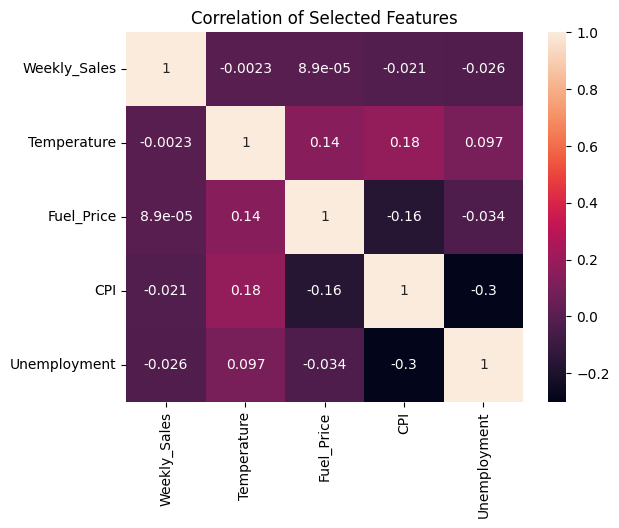

In [315]:
# plotting correlation heatmap of selected features
sns.heatmap(df[['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']].corr(), annot=True)
plt.title('Correlation of Selected Features')
plt.show()

In [316]:
# remove Date column
# as we have extracted useful features from it
df = df.drop(columns=['Date'])

In [317]:
# check first 5 rows of the final dataframe
df.head(5)

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,Day
0,1,1,24924.50,42.31,2.572,211.096358,8.106,False,2010,2,5,5
1,1,1,46039.49,38.51,2.548,211.242170,8.106,True,2010,2,6,12
2,1,1,41595.55,39.93,2.514,211.289143,8.106,False,2010,2,7,19
3,1,1,19403.54,46.63,2.561,211.319643,8.106,False,2010,2,8,26
4,1,1,21827.90,46.50,2.625,211.350143,8.106,False,2010,3,9,5


In [318]:
# no. of unique stores in the dataframe
df['Store'].nunique()

45

In [319]:
# no. of unique departments in the dataframe
df['Dept'].nunique()

81

In [320]:
# no. of unique years in the dataframe
df['Year'].nunique()

3

In [321]:
# group by Year and sum of Weekly_Sales
yearly_sales = df.groupby('Year')['Weekly_Sales'].sum()

In [322]:
# group by Month and sum of Weekly_Sales
monthly_sales = df.groupby('Month')['Weekly_Sales'].sum()

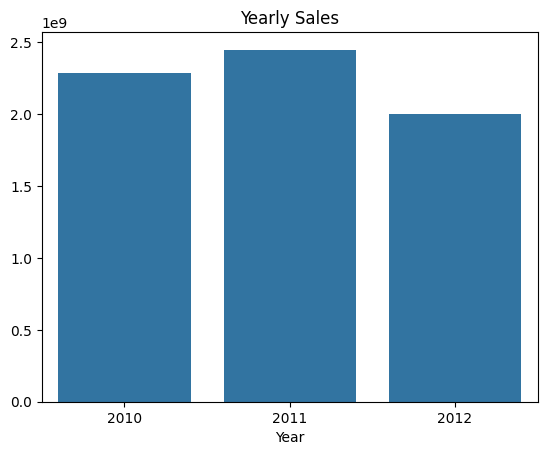

In [323]:
# plot yearly sales
sns.barplot(x=yearly_sales.index,y=yearly_sales.values)
plt.title('Yearly Sales')
plt.show()

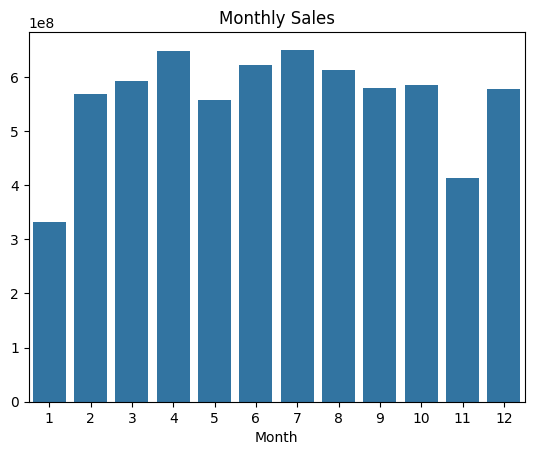

In [324]:
# plot monthly sales
sns.barplot(x=monthly_sales.index,y=monthly_sales.values)
plt.title('Monthly Sales')
plt.show()

In [325]:
# convert IsHoliday column to integer type
df['IsHoliday'] = df['IsHoliday'].astype(int)

In [326]:
# check value counts of IsHoliday column
df['IsHoliday'].value_counts()

IsHoliday
0    390652
1     29560
Name: count, dtype: int64

# Model Building


- We will build a regression models like Linear Regression, Random Forest, and XGBoost to predict the **Weekly_Sales** based on the other features in the dataset.

In [327]:
# defining feature columns and target column
feature = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week', 'Day']
target = ['Weekly_Sales']       

In [328]:
# splitting features and target variable
X = df[feature]
y = df[target]

In [329]:
# rows and columns in feature set
X.shape

(420212, 11)

In [330]:
# rows and columns in target variable
y.shape

(420212, 1)

In [331]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [332]:
# rows and columns in training feature set
X_train.shape

(336169, 11)

In [333]:
# rows and columns in testing feature set
X_test.shape

(84043, 11)

In [334]:
# rows and columns in training target set
y_train.shape

(336169, 1)

In [335]:
# rows and columns in testing target set
y_test.shape

(84043, 1)

In [336]:
# columns in feature set
X.columns

Index(['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')

In [337]:
# cyclic transformations for day and month
# if we apply directly standard scaler
# then model think 31 and 1 or 12 and 1
# are far way so we first use sin and cos
# and then use standard scaler

X_train['Day_sin'] = np.sin(2 * np.pi * X_train['Day'] / 31)
X_train['Day_cos'] = np.cos(2 * np.pi * X_train['Day'] / 31)

X_test['Day_sin'] = np.sin(2 * np.pi * X_test['Day'] / 31)
X_test['Day_cos'] = np.cos(2 * np.pi * X_test['Day'] / 31)

X_train['Month_sin'] = np.sin(2 * np.pi * X_train['Month'] / 12)
X_train['Month_cos'] = np.cos(2 * np.pi * X_train['Month'] / 12)

X_test['Month_sin'] = np.sin(2 * np.pi * X_test['Month'] / 12)
X_test['Month_cos'] = np.cos(2 * np.pi * X_test['Month'] / 12)

# drop original month and day
X_train = X_train.drop(columns=['Day','Month'])
X_test = X_test.drop(columns=['Day','Month'])

In [338]:
# columns in feature set
X_train.columns

Index(['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'Year', 'Week', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos'],
      dtype='object')

In [339]:
# standard scaling of feature set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [340]:
# defining and training Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [341]:
# predictions of Linear Regression model on test set
y_pred_linear_reg = linear_reg.predict(X_test)

In [342]:
# function to evaluate model performance
def evaluate_metrics(y_pred,y_test=y_test):
    mae = mean_absolute_error(y_test,y_pred)
    rmse = root_mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    return mae,rmse,r2

In [343]:
# function to print evaluation metrics
def print_metrics(model,mae,rmse,r2):
    print(f"Evaluation Metrics of {model}")
    print(f"MAE : {mae}")
    print(f"RMSE : {rmse}")
    print(f"R2Score : {r2}")

In [344]:
# defining metrics like
# mean absolute error, root mean squared error, r2 score
# for linear regression model
mae_lg,rmse_lg,r2_lg = evaluate_metrics(y_pred_linear_reg)

In [345]:
# print evaluation metrics for Linear Regression model
print_metrics("Linear Regression",
mae_lg,rmse_lg,r2_lg)

Evaluation Metrics of Linear Regression
MAE : 15090.237083384369
RMSE : 22202.360736644532
R2Score : 0.03496592963535983


## Random Forest Regressor

In [346]:
# defining and training Random Forest Regressor model
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [347]:
# predictions of Random Forest Regressor model on test set
y_pred_random_forest_reg = random_forest_reg.predict(X_test)

In [348]:
# defining metrics like
# mean absolute error, root mean squared error, r2 score
# for Random Forest Regressor model
mae_rf,rmse_rf,r2_rf = evaluate_metrics(y_pred_random_forest_reg)

In [349]:
# print evaluation metrics for Random Forest Regressor model
print_metrics(
    "RandomForest Regressor",
    mae_rf,rmse_rf,r2_rf
)

Evaluation Metrics of RandomForest Regressor
MAE : 1432.9156112656615
RMSE : 3785.8730176964873
R2Score : 0.9719407264299315


In [350]:
# checking feature importances
# from the trained Random Forest Regressor model
random_forest_reg.feature_importances_

array([2.68974362e-01, 5.64005947e-01, 1.17153177e-02, 6.04325349e-03,
       6.08421285e-02, 3.23227558e-02, 5.34434061e-04, 5.97874555e-04,
       2.83484472e-02, 1.11189408e-02, 4.20741437e-03, 5.30758665e-03,
       5.98153788e-03])

In [351]:
# columns variable with feature names after
# cyclic transformation and dropping Day and Month
columns = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'Year', 'Week', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos']

In [352]:
# checking number of features
# in Random Forest Regressor model
random_forest_reg.n_features_in_

13

## Light GBM

In [353]:
# defining training and test datasets
# for LightGBM model
train_data_lightgbm = lgb.Dataset(
    X_train, label=y_train
)
test_data_lightgbm = lgb.Dataset(
    X_test, label= y_test, reference=train_data_lightgbm
)

In [354]:
# defining parameters for LightGBM model
params = {
    "objective":"regression",
    "boosting_type":"gbdt",
    "num_leaves": 31,
    "learning_rate": 0.1,
}
# training LightGBM model
light_gbm = lgb.train(
    params,
    train_data_lightgbm,
    num_boost_round=1000,
    valid_sets=[train_data_lightgbm,test_data_lightgbm],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 336169, number of used features: 13
[LightGBM] [Info] Start training from score 16025.337168


In [355]:
# predictions of LightGBM model on test set
y_pred_light_gbm = light_gbm.predict(X_test)

In [356]:
# defining metrics like
# mean absolute error, root mean squared error, r2 score
# for LightGBM model
mae_lgbm,rmse_lgbm,r2_lgbm = evaluate_metrics(
    y_pred_light_gbm
)

In [357]:
# print evaluation metrics for LightGBM model
print_metrics(
    "LightGBM",
    mae_lgbm,rmse_lgbm,r2_lgbm
)

Evaluation Metrics of LightGBM
MAE : 2585.771460245413
RMSE : 4422.425883379841
R2Score : 0.9617117547243882


## XGBoost

In [358]:
# defining and training XGBoost model
xgboost = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgboost.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [359]:
# predictions of XGBoost model on test set
y_pred_xgboost = xgboost.predict(X_test)

In [360]:
# defining metrics like
# mean absolute error, root mean squared error, r2 score
# for XGBoost model
mae_xgb,rmse_xgb,r2_xgb = evaluate_metrics(
    y_pred_xgboost
)

In [361]:
# print evaluation metrics for XGBoost model
print_metrics(
    "XGBoost",
    mae_xgb,rmse_xgb,r2_xgb
)

Evaluation Metrics of XGBoost
MAE : 5834.39111328125
RMSE : 9882.1494140625
R2Score : 0.8088179230690002


In [362]:
# calculating residuals for XGBoost model
residuals_xgboost = y_test.values.ravel() - y_pred_xgboost 

In [363]:
# calculating residuals for LightGBM model
residuals_random_forest = y_test.values.ravel() - y_pred_random_forest_reg

In [364]:
# mean of residuals for XGBoost model
np.mean(residuals_xgboost)

np.float64(41.84581954504155)

In [365]:
# mean of residuals for LightGBM model
np.mean(residuals_random_forest)

np.float64(-30.775166850302867)

In [366]:
# calculating residuals for LightGBM model
residuals_lgbm =  y_test.values.ravel() - y_pred_light_gbm

In [367]:
# mean of residuals for LightGBM model
np.mean(residuals_lgbm)

np.float64(27.39350947391212)

In [368]:
# printing standard deviation of residuals
# for each model
print(f"Residuals standard deviation of  Random Forest : {np.std(residuals_random_forest)}")
print(f"Residuals standard deviation of LightGBM : {np.std(residuals_lgbm)}")
print(f"Residuals standard deviation of XGBoost : {np.std(residuals_xgboost)}")

Residuals standard deviation of  Random Forest : 3785.7479307565686
Residuals standard deviation of LightGBM : 4422.341041759067
Residuals standard deviation of XGBoost : 9882.060860773827


In [369]:
# checking shapes and types of y_test and y_pred_xgboost
# type of y_pred_xgboost
print(y_test.shape)
print(y_pred_xgboost.shape)
type(y_pred_xgboost)

(84043, 1)
(84043,)


numpy.ndarray

As, only tree models can provide feature importance directly, we will focus on them and check linear regression coefficients which is weight given to each feature.

In [370]:
# printing coefficients of linear regression model
# which are weights assigned to each feature
linear_reg.coef_

array([[-2093.10981929,  3436.22677554,   835.25505953,    39.8983547 ,
        -1194.73153122,  -662.97822833,   192.1472875 ,  -161.86480238,
         1480.39269403,    87.42868264,   -62.40359395,  1573.34821208,
          460.77578915]])

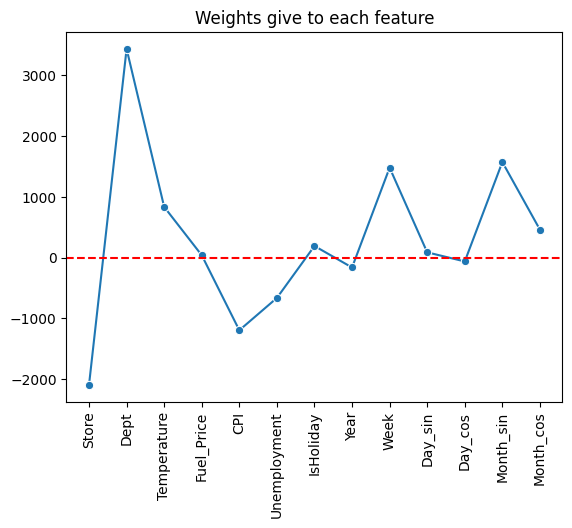

In [371]:
# plotting weights assigned to each feature
# of linear regression model
sns.lineplot(x=columns,y=linear_reg.coef_.flatten(),
marker="o")
plt.xticks(rotation=90)
plt.axhline(0,linestyle="--",color='red')
plt.title("Weights give to each feature")
plt.show()

---

- As, we can see that linear regression coefficients are not giving much insight as some features have **negative** and some have **positive** values.
- Hence, it is difficult to interpret feature importance from linear regression coefficients. 
- So, now we plot feature importance from tree based models and compare them.

---

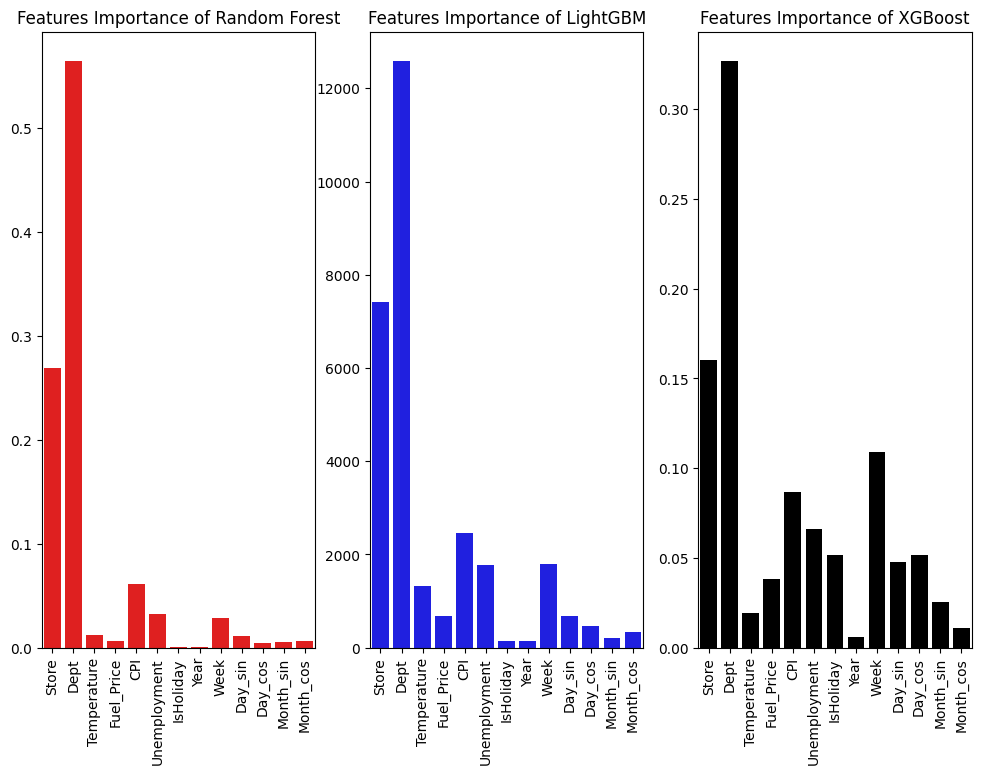

In [372]:
# plotting feature importances
# from Random Forest, LightGBM and XGBoost models
# in 3 subplots
fig, axes = plt.subplots(1,3, figsize=(12,8))


sns.barplot(x=columns,y=random_forest_reg.feature_importances_,
color="red", ax = axes[0])

axes[0].set_title("Features Importance of Random Forest")

sns.barplot(x=columns,y=light_gbm.feature_importance(),
color="blue",  ax = axes[1])

axes[1].set_title("Features Importance of LightGBM")

sns.barplot(x=columns,y=xgboost.feature_importances_,
color="black", ax=axes[2])

axes[2].set_title("Features Importance of XGBoost")

for ax in axes:
    ax.tick_params(axis='x',rotation=90)

---


---

### 🔎 Feature Importance Comparison

**Random Forest**

* **Top Features:** `Dept`, `Store`, `CPI`, `Unemployment`, `Week`
* **Minor Features:** `Temperature`, `Fuel_Price`, cyclic (`sin–cos`) features
* **Notes:** Focuses on key business and economic indicators; simple and interpretable.

**LightGBM**

* **Top Features:** `Dept`, `Store`, `CPI`, `Unemployment`, `Week`, `Temperature`, `Fuel_Price`
* **Minor Features:** `Day_sin`, `Day_cos`, `Month_sin`, `Month_cos`
* **Notes:** Captures both economic and temporal signals; balanced feature importance.

**XGBoost**

* **Top Features:** All features contribute almost equally
* **Notes:** Distributes importance uniformly; less interpretable.

---

### 🧠 Interpretation

* **Random Forest:** Emphasizes main business and economic features.
* **LightGBM:** Includes additional temporal and economic signals; more nuanced importance.
* **XGBoost:** Treats all features roughly equally, reducing interpretability.

---

### 🏆 Recommendation

* **For explaining feature importance:** Use **Random Forest** or **LightGBM**.
* **For best predictive performance:** **XGBoost**, but interpretability is lower.

---



## 📊 Evaluation Metrics Comparison (R² in %)


---

| Model                       | MAE       | RMSE      | R² Score   |
| --------------------------- | --------- | --------- | ---------- |
| **Linear Regression**       | 15,090.24 | 22,202.36 | **3.50%**  |
| **Random Forest Regressor** | 1,432.91  | 3,785.87  | **97.19%** |
| **LightGBM**                | 2,585.77  | 4,422.43  | **96.17%** |
| **XGBoost**                 | 5,834.39  | 9,882.15  | **80.88%** |

---

>## ⚠️  **Observation:**

> The **Linear Regression** model performs poorly, likely due to complex non-linear relationships in the sales data.
> Therefore, from now on, we will **focus on the other, more robust models** (Random Forest, LightGBM, and XGBoost).

---


---

## 🧾 Residual Analysis Summary


| Model                       | Mean Residual   | Std. of Residuals | Direction                 | Interpretation                        |
| --------------------------- | --------------- | ----------------- | ------------------------- | ------------------------------------- 
|
| **Random Forest Regressor** | **–30.77**      | **3,785.74**      | 🔽 Overpredicts slightly  | Predictions are the most consistent and closest to actual values. |
| **LightGBM**                | **+27.39**      | **4,422.34**      | 🔼 Underpredicts slightly | Predictions a bit lower than actuals  |
| **XGBoost**                 | **+41.00**      | **9,882.06**      | 🔼 Underpredicts slightly | Predictions slightly below actuals    |



---

## 🏁 Model Ranking Based on Residual Analysis

🥇 **Random Forest Regressor**

* **Mean Residual:** –30.77 🔹 (slight overprediction)
* **Residual Std:** 3,785.74 🟢 (lowest → most consistent)
* **Notes:** Best overall performance — very stable and reliable predictions.

🥈 **LightGBM**

* **Mean Residual:** +27.39 🔹 (slight underprediction)
* **Residual Std:** 4,422.34 🟡 (slightly higher spread)
* **Notes:** Good accuracy and fairly consistent; minor variability.

🥉 **XGBoost**

* **Mean Residual:** +41.00 🔹 (slight underprediction)
* **Residual Std:** 9,882.06 🔴 (highest → least consistent)
* **Notes:** Predictions are less stable due to high variability, though overall performance is decent.

---

✅ **Summary:**

* **Random Forest Regressor** → Most **balanced, stable, and reliable** predictions.
* **LightGBM** → Close second, slightly higher residual spread.
* **XGBoost** → Less consistent due to large residual variability.

---



---

## ✅ Recommended Model: Random Forest Regressor

### **Reasoning**

* 🏆 **Highest R² score:** ≈ **97.19%** → explains most of the variance in target values
* 📉 **Lowest RMSE:** ≈ **3,785.87** → most consistent and accurate predictions
* 🔹 **Residual standard deviation:** ≈ **3,785.74** → smallest spread of errors
* 🔹 **Residual mean:** –30.77 → minimal bias (slight overprediction)

* ✅ Supports **early stopping**, **feature importance extraction**, and **cross-platform deployment**

---

### ⚠️ Observation

* Among the robust models (**Random Forest, LightGBM, XGBoost**), **Random Forest** provides the **most balanced, accurate, and reliable predictions**.

---



---

## ⏱ Model Performance vs Training Time

| Model                       | R² Score | RMSE     | Training Time  | Notes                                                                               |
| --------------------------- | -------- | -------- | -------------- | ----------------------------------------------------------------------------------- |
| **Random Forest Regressor** | 97.19%   | 3,785.87 | ~8 minutes   | Highest accuracy and most consistent predictions; slowest to train.                 |
| **LightGBM**                | 96.17%   | 4,422.43 | ~22 seconds | Slightly lower accuracy, very fast training; good balance of speed and performance. |
| **XGBoost**                 | 80.88%   | 9,882.15 | ~3 seconds   | Faster among all, but lower accuracy; less stable predictions.             |

---

### 💡 Key Insights

* **Random Forest** → Best overall for **accuracy and stability**, but **training is slow**.
* **LightGBM** → Slightly lower accuracy, but **much faster**; good for quick experimentation or large datasets.
* **XGBoost** → Fastest but **accuracy and consistency are weaker** in this dataset.

---

